In [1]:
#Importing packages

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import image
from keras.models import Sequential
from keras import layers
from keras.layers import Flatten, Dense, Dropout, Activation
# from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import Conv2D
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
from shutil import move


import csv

Using TensorFlow backend.


## Splitting the pneumonia into viral and bacteria foldersfolders

In [2]:
#Splitting the pneumonia into viral and bacteria foldersfolders
train_location="chest_xray/train"
test_location="chest_xray/test"
orig_train_pneumonia="chest_xray/train/PNEUMONIA"
orig_test_pneumonia="chest_xray/test/PNEUMONIA"

In [3]:
#Definition to move viral and bacteria pneumonia images into differenct directory and remove the parent directory.
#Purpose is to be able to use ImageDataGenerator.flow_from_direcotry()
def reorganize_files(pneumonia_directory, parent_directory):
    bac_dir=parent_directory + "/Bacterial"
    vir_dir=parent_directory + "/Viral"
    
    os.mkdir(bac_dir)
    os.mkdir(vir_dir)
    
    for filename in os.listdir(pneumonia_directory):
        if (filename.lower().find("bacteria") == -1): #Did not contain bacteria in name, must be viral.
            move(pneumonia_directory+"/"+filename,vir_dir)
        else: #This is bacterial pneumonia.
            move(pneumonia_directory+"/"+filename,bac_dir)
                 
    os.rmdir(pneumonia_directory)
        

In [4]:
#Check if the folder were indeed been organized., if not, move it.

if(os.path.exists(orig_train_pneumonia)):
    reorganize_files(orig_train_pneumonia, train_location)
    
if(os.path.exists(orig_test_pneumonia)):
    reorganize_files(orig_test_pneumonia, test_location)


# Preview the Images


In [5]:
#Load a test image and see everything loaded

location = "chest_xray/train/NORMAL"
location_b = "chest_xray/train/Bacterial"
location_v ="chest_xray/train/Viral"

train_normal_example = plt.imread(location + "/IM-0311-0001.jpeg")
train_bacterial_example = plt.imread(location_b + "/person1000_bacteria_2931.jpeg")
train_Viral_example = plt.imread(location_v + "/person1000_virus_1681.jpeg")
#As this is black and white image, it only has one dimension.

print(train_normal_example.shape)
print(train_bacterial_example.shape)
print(train_Viral_example.shape)

(885, 1268)
(760, 1152)
(768, 1072)


Text(0.5, 1.0, 'Viral')

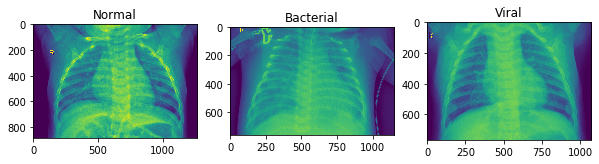

In [6]:
f = plt.figure(figsize= (10,6))
a0 = f.add_subplot(1, 3, 1)
img_plot = plt.imshow(train_normal_example)
a0.set_title('Normal')

a1 = f.add_subplot(1,3,2)
img_plot = plt.imshow(train_bacterial_example)
a1.set_title('Bacterial')

a2 = f.add_subplot(1, 3, 3)
img_plot = plt.imshow(train_Viral_example)
a2.set_title('Viral')

### Load dataset

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                 height_shift_range=0.2,
                                 width_shift_range=0.2,
                                 horizontal_flip = True)

test_datagen=ImageDataGenerator(rescale=1./255)

image_classes=["Bacterial", "NORMAL", "Viral"]


training_set = train_datagen.flow_from_directory(train_location,
                                                 target_size = (224, 224), #For transfer Learning.  Make sure to change it to your input.
                                                 batch_size = 32,
                                                 classes=image_classes,
                                                 shuffle=True,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_location,
                                                 target_size = (224, 224),
                                                 batch_size = 24,
                                                 classes=image_classes,
                                                 shuffle=False,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


# Build CNN

# data augmentation
# transfer learning
# Analysis after model building: confusion matrix, precision, recall, f1 score

In [8]:
#Getting VGG19

from keras.applications import VGG19, VGG16, ResNet50

# VGG19_base_model = VGG19(weights="imagenet", input_shape=(224,224,3))
# VGG19_base_model.summary()

#resnet_base_model=ResNet50(weights="imagenet", input_shape=(224,224,3))
# resnet_base_model.summary()

In [9]:
#Making a class to make it easier to fine tune models.

class modelCreator:
    def __init__(self, model_name,base_model, Dense_Layer_Configurations, AddDropOut=True, Dropout_Float=0.2, Freeze_Model_Layer=True):
        self.model_name=model_name
        self.base_model=base_model
        self.Dense_Layer_Configurations=Dense_Layer_Configurations
        self.AddDropOut=AddDropOut
        self.Dropout_Float=Dropout_Float
        self.Freeze_Model_Layer=Freeze_Model_Layer
        
    def configureModel(self, lastLayer):
        previousLayer=lastLayer
        index=0
            
        for neurons in self.Dense_Layer_Configurations[:-1]: #Do not include the last layer as it is definitely softmax.  Adding it seperately.
            fc=Dense(neurons, activation='relu')(previousLayer)
            index+=1
            previousLayer=fc
            if(self.AddDropOut):
                fc=Dropout(self.Dropout_Float)(previousLayer)
                previousLayer=fc
                index+=1
    
        #Adding softmax
        softmaxLayer=Dense(3, activation='softmax')(previousLayer)
        index+=1
        self.model=Model(self.base_model.inputs,softmaxLayer)
        
        if(self.Freeze_Model_Layer): #This is to determine whether we should only train weights that are in the pre-trained network.
            for layer in self.model.layers[:-1*index]:  #Only go up to last flatten layer.
                layer.trainable=False
        
    def combineModels(self):
        #Freeze models
        if(self.model_name.lower() == "vgg19" or self.model_name.lower() == "vgg16"):
            
            baseOutput=self.base_model.get_layer("block5_pool").output #Block5_pool is the last output
            flatten=Flatten()(baseOutput) #Add the flatten layer
            
            self.configureModel(flatten)           
            
#             for neurons in self.Dense_Layer_Configurations[:-1]:
#                 fc=Dense(neurons, activation='relu')(previousLayer)
#                 index+=1
#                 if(self.AddDropOut):
#                     fc=Dropout(self.Dropout_Float)(fc)
#                     index+=1
#                 previousLayer=fc
            
#             softmaxLayer=Dense(3, activation='softmax')(previousLayer)
#             index+=1
#             self.model=Model(self.base_model.inputs,softmaxLayer)
            
#             if(self.Freeze_Model_Layer):
#                 for layer in self.model.layers[:-1*index]:
#                     layer.trainable=False
            return self.model

        elif(self.model_name.lower()=="resnet"): #too bad python doesn't have switch statements....
            baseOutput=self.base_model.layers[-3].output
            flatten=Flatten()(baseOutput)
            self.configureModel(flatten)
            return self.model
        else:
            print("Please double check your model name and try again")

        

In [10]:
File_Name = "CNN_Results.csv"
ResultsDict = {}

Column_Header = ["Model Name", "Layer Configurations", "Dropout Enabled", "Dropout Percentage", "Froze PreTrained Model Weights", "Optimizer", "Batch", "Epoch", "Accuracy Score", "Average Macro Precision Score", "Average Macro F1 Score", "Average Macro Recall Score"]

with open(File_Name, 'w', newline='') as csvfile: 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(Column_Header)


In [11]:
#Compile Model Method
class compileModel:
    def __init__(self,model, optimizer_name="sgd", learning_rate=0.01, decay=0.1,momentum=0.1,metrics=["accuracy"]):
        self.model=model
        self.optimizer_name=optimizer_name
        self.learning_rate=learning_rate
        self.decay=decay
        self.momentum=momentum
        self.metrics=metrics
        
    def compile_model(self):
        if(self.optimizer_name.lower() == "sgd"):
            self.optimizer=SGD(learning_rate=self.learning_rate, momentum=self.momentum)
        else:
            self.optimizer="Adam"
        
        self.model.compile(loss="categorical_crossentropy", optimizer=self.optimizer, metrics=self.metrics)
        return self.model
    

In [12]:
def FitModel(model, number_of_batches, validation_batches, epoch, show_progress=False):
    
    if(show_progress):
        show=1
    else:
        show=0
        
    history = model.fit_generator(generator=training_set,
                                 steps_per_epoch=number_of_batches,
                                 epochs=epoch,
                                 verbose=show,
                                 validation_data=test_set,
                                 validation_steps=validation_batches)
    
    return history

In [13]:
# modelObj = modelCreator(model_name="VGG19", 
#                            base_model=VGG19_base_model, 
#                            Dense_Layer_Configurations=[1000,400,150,70,20,6,3], 
#                            AddDropOut=True, 
#                            Dropout_Float=0.2,
#                            Freeze_Model_Layer=True)

# model=modelObj.combineModels()

# modelCompiler=compileModel(model=model)
# model=modelCompiler.compile_model()


# history=FitModel(model, 60, 10, 100,True)

In [13]:
def writeFilesAndSaveDictionary(ModelDict, ScoreDict, DictKey, ScoreList):
    ResultsDict[DictKey] = ScoreList
    
    with open(File_Name, 'a', newline='') as csvfile:
        file_writer = csv.writer(csvfile)
        neurons = ""
        for neuron in ModelDict["Layer Configurations"]: #can't simply go to toString as it will add period and screw up csv.
            neurons += str(neuron) + "_"
        
        ModelDict["Layer Configurations"] = neurons
        
        row = []
        
        for i in ModelDict:
            row.append(str(ModelDict[i]))
        
        for j in ScoreDict:
            row.append(str(ScoreDict[j]))

        file_writer.writerow(row)

In [14]:
#Try out different parameters.
XferLearningModels = ["VGG19", "VGG16"]
#XferLearningModels = ["ResNet"] #-- Ran out of memory for ResNet
DenseConfigurations = [[500,150,70,20,6,3],
                       [700, 200, 80, 30, 10,3],
                       [1500,500,150,50,20,8,3],
                      [2000,1000,500,250,125,40,10,3]]
Dropouts = [True, False]
DropoutFloat = [0.2,0.5,0.3,0.4]
Freeze_Model_Layer = [True, False]
                       
Optimizers=["Adam", "sgd"]

Batches=[20,30,50,100]
Epochs= [30,50,80]

In [16]:
def DictKeyGenerator(list):
    key = ""
    for i in list:
        key += str(i) + " "
        
    return key

In [15]:
#Tuning Evertyhing accorid

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from random import randint

for i in range(0,200): #200 models are way too much.  Ran out of memory.
    
    #Due to time and budget constraint, cannot search through every model combination one by one that I want to explroe.  Hence implementing a random search to tune the hyperparameter settings.
    XferLearningModels_Index = randint(0,len(XferLearningModels)-1)
    DenseConfigurations_Index = randint(0,len(DenseConfigurations)-1)
    Dropouts_Index = randint(0,len(Dropouts)-1)
    DropoutFloat_Index = randint(0,len(DropoutFloat)-1)
    Freeze_Model_Layer_Index=randint(0,len(Freeze_Model_Layer)-1)
    Optimizers_Index=randint(0,len(Optimizers)-1)
    Batches_Index=randint(0,len(Batches)-1)
    Epochs_Index=randint(0,len(Epochs)-1)
    
    if(XferLearningModels[XferLearningModels_Index].lower() == "vgg19"):
        base_model = VGG19(weights="imagenet", input_shape=(224,224,3))
    elif(XferLearningModels[XferLearningModels_Index].lower()=="vgg16"):
        base_model = VGG16(weights="imagenet", input_shape=(224,224,3))
    else:
        base_model = ResNet50(weights="imagenet", input_shape=(224,224,3))
    
    #Using the above 
    Model_Settings = {}
    Model_Settings["Model Name"] = XferLearningModels[XferLearningModels_Index]
    Model_Settings["Layer Configurations"] = DenseConfigurations[DenseConfigurations_Index]
    Model_Settings["Dropout Enabled"] = Dropouts[Dropouts_Index]
    Model_Settings["Dropout Percentage"] = DropoutFloat[DropoutFloat_Index]
    Model_Settings["Froze PreTrained Model Weights"] = Freeze_Model_Layer[Freeze_Model_Layer_Index]
    Model_Settings["Optimizer"] = Optimizers[Optimizers_Index]
    Model_Settings["Batch"] = Batches[Batches_Index]
    Model_Settings["Epoch"] = Epochs[Epochs_Index]
    
    #Using the above to get the key to input into the ResultsDict {}
    keyCombination = [XferLearningModels[XferLearningModels_Index],
                     DenseConfigurations[DenseConfigurations_Index],
                     Dropouts[Dropouts_Index],
                     DropoutFloat[DropoutFloat_Index],
                     Freeze_Model_Layer[Freeze_Model_Layer_Index],
                     Optimizers[Optimizers_Index],
                     Batches[Batches_Index],
                     Epochs[Epochs_Index]]
    
    DictKey=DictKeyGenerator(keyCombination)
    
    #Make sure this model hasn't been run before.
    if(ResultsDict.get(DictKey) != None): #This model has already been run.
        continue
        
    
    #Creating Model    
    modelObj = modelCreator(model_name=XferLearningModels[XferLearningModels_Index], 
                    base_model=base_model, 
                    Dense_Layer_Configurations=DenseConfigurations[DenseConfigurations_Index],
                    AddDropOut=Dropouts[Dropouts_Index], 
                    Dropout_Float=DropoutFloat[DropoutFloat_Index],
                    Freeze_Model_Layer=Freeze_Model_Layer[Freeze_Model_Layer_Index])
    
    model=modelObj.combineModels()
    
    #Compile Model
    modelCompiler=compileModel(model=model, optimizer_name=Optimizers[Optimizers_Index])
    model=modelCompiler.compile_model()
    
    #Fitting Model    
    history = FitModel(model, Batches[Batches_Index], 26, Epochs[Epochs_Index], True)

    #Make the prediction
    y_predict = model.predict_generator(generator=test_set, steps=26)
    
    #Un-One hot encode and just use label encode
    predict_labels=y_predict.argmax(axis=1)
    test_labels = test_set.classes
    
    #Get all the scores.  Macro indicate a non-weighted average.  Hence it would be the same for slightly skewed results.
    ac=accuracy_score(test_labels, predict_labels)
    ps=precision_score(test_labels, predict_labels, average="macro")
    fs=f1_score(test_labels, predict_labels, average="macro")
    rs=recall_score(test_labels, predict_labels, average="macro")
                                
    Scores = {}
    Scores["Acc_Score"] = ac
    Scores["Pre_Score"] = ps
    Scores["F1_Score"] = fs
    Scores["Rec_Score"] = rs
    Scores_list = [ac,ps,fs,rs]
                                
    writeFilesAndSaveDictionary(Model_Settings, Scores, DictKey, Scores_list)

KeyboardInterrupt: 

In [17]:
    winningModelobj = modelCreator(model_name="VGG16", 
                    base_model=VGG16(weights="imagenet", input_shape=(224,224,3)), 
                    Dense_Layer_Configurations=[700, 200, 80, 30, 10,3],
                    AddDropOut=False, 
                    Dropout_Float=0.5,
                    Freeze_Model_Layer=True)
    
    winningModel=winningModelobj.combineModels()
    
    #Compile Model
    winningModelCompiler=compileModel(model=winningModel, optimizer_name="sgd")
    winningModel=winningModelCompiler.compile_model()
    
    #Fitting Model    
    history = FitModel(winningModel, 50, 26, 80, True)

    #Make the prediction
    y_predict = winningModel.predict_generator(generator=test_set, steps=26)
    
    #Un-One hot encode and just use label encode
    predict_labels=y_predict.argmax(axis=1)
    test_labels = test_set.classes

Epoch 1/80
50/50 [==============================] - 47s 938ms/step - loss: 1.0969 - accuracy: 0.4144 - val_loss: 1.2024 - val_accuracy: 0.3878
Epoch 2/80
50/50 [==============================] - 37s 733ms/step - loss: 1.0617 - accuracy: 0.4831 - val_loss: 1.3324 - val_accuracy: 0.3878
Epoch 3/80
50/50 [==============================] - 38s 750ms/step - loss: 0.9960 - accuracy: 0.5181 - val_loss: 1.3742 - val_accuracy: 0.3878
Epoch 4/80
50/50 [==============================] - 35s 707ms/step - loss: 0.9711 - accuracy: 0.5681 - val_loss: 1.4913 - val_accuracy: 0.4679
Epoch 5/80
50/50 [==============================] - 34s 682ms/step - loss: 0.9289 - accuracy: 0.5631 - val_loss: 1.6386 - val_accuracy: 0.6442
Epoch 6/80
50/50 [==============================] - 35s 699ms/step - loss: 0.8764 - accuracy: 0.6006 - val_loss: 1.2396 - val_accuracy: 0.5641
Epoch 7/80
50/50 [==============================] - 34s 687ms/step - loss: 0.8099 - accuracy: 0.6294 - val_loss: 0.8914 - val_accuracy: 0.6010

In [17]:
winningModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

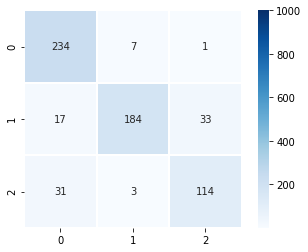

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix=confusion_matrix(test_labels, predict_labels)

matrix=sns.heatmap(confusion_matrix,linewidths=1,vmax=1000,
square=True, cmap="Blues",annot=True, fmt="1")

ac=accuracy_score(test_labels, predict_labels)
print("Test accuracy: " + ac)


In [25]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'Bacterial', 'Viral']
print(classification_report(test_labels, predict_labels, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.83      0.97      0.89       242
   Bacterial       0.95      0.79      0.86       234
       Viral       0.77      0.77      0.77       148

    accuracy                           0.85       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.86      0.85      0.85       624

